#### Analisis de Datos y Modelamiento Predictivo

Una de las preguntas principales que buscamos responder con el proyecto, es si la concurencia de las olas de calor en comparacion al pasado. La cual es una pregunta que se responde con un si o no. Por ello podria decirce que es un problema de calificacion. 

Como el objetivo principal es predecir la ocurrecia de una Ola de Calor en base a los datos meteorologicos que obtuvimos,  como Presipitaciones, Humedad, Presion Atmosferica, Radiacion UV, y Temperaturas maximas.

Como dije este es un problema de calificacion y como puede dar como resultado SI o NO. Entonces podemos definir la variable (Y), como (Y = 1) -> si se registra una Ola de calor en un mes o conjunto de dias dado, o (Y=0) si no se registra una ola de calor.

Para crear la variable Y me enfocare en las temperaturas maximas mensuales, donde si la temperatura maxima mensual supera el percentil 90 historico de todas las temperaturas maximas se etiquetara un mes como (Y=1).

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

#### Preparacion de los Datos para Modelar

In [2]:
# PRIMERO Cargar los datos
archivos = ["maximo_temperaturas_maximas_santiago.csv","humedad_mensual_santiago.csv","precipitaciones_mensuales_santiago.csv",
    "presion_mensual_santiago.csv","maximo_uvb_santiago.csv"]

df_unifi = pd.read_csv("data_temperatura/" + archivos[0])

# Lo transformo un poco para su uso correcto en esta parte
if 'Años' in df_unifi.columns:
    df_unifi = df_unifi.rename(columns={'Años': 'Año'})
if 'Anual' in df_unifi.columns:
    df_unifi = df_unifi.drop(columns=['Anual'])

# Asi es mas facil unir

df_unifi = df_unifi.set_index('Año')

# Itero sobre los otros archivos
for i in range(1, len(archivos)):
    df_temporal = pd.read_csv("data_temperatura/" + archivos[i])
    if 'Años' in df_temporal.columns:
        df_temporal = df_temporal.rename(columns={'Años': 'Año'})
    df_temporal = df_temporal.set_index('Año')

    df_unifi = pd.merge(df_unifi, df_temporal, left_index=True, right_index=True,
                        how='outer', suffixes=(f'_{archivos[i-1].split("_")[0]}', f'_{archivos[i].split("_")[0]}'))

df_unifi = df_unifi.reset_index()
#df_unifi.info()
#display(df_unifi.columns)

In [3]:
# Ahora que tengo el dataframe unificado lo voy a transformar, para poder realizar correctamente el modelo
cols_objetivo = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

columnas = list(df_unifi.columns)
# Esta parte obtiene los prefijos de las columnas que contienen '_'
prefijos = (col.split('_')[1] for col in columnas if '_' in col)

# Esta parte hace que sea unico, luego los hace una lista para poder ordenarlos
prefijos_auxiliares =sorted(list(set(prefijos))) 

df_temp_1 = df_unifi.melt(id_vars=['Año'], value_vars=cols_objetivo,
            var_name='Mes', value_name='Temperatura_Max')

df_final = df_temp_1.copy()

# Ahora transformo y fusiono las variables auxiliares para otro dataframe y los conecto en uno
for prefijo in prefijos_auxiliares:
    cols_auxiliares = []
    for col in columnas:
        if col.endswith(f'_{prefijo}'):
            cols_auxiliares.append(col)
    
    df_auxiliar = df_unifi.melt(id_vars=['Año'], value_vars=cols_auxiliares, 
            var_name='Mes_Prefijo', value_name=f'Valor_{prefijo}')

    # Extraigo el nombre del mes de la columna Mes_prefijo
    df_auxiliar['Mes'] = df_auxiliar['Mes_Prefijo'].apply(lambda x: x.split('_')[0])
    # Luego hacemos un mapeo a los nombre completos de los meses 
    nombre_mes = {'Ene': 'Enero', 'Feb': 'Febrero', 'Mar': 'Marzo', 'Abr': 'Abril', 'May': 'Mayo', 'Jun': 'Junio',
        'Jul': 'Julio', 'Ago': 'Agosto', 'Sep': 'Septiembre', 'Oct': 'Octubre', 'Nov': 'Noviembre', 'Dic': 'Diciembre'}
    
    # Uso map que mapea de un valor key a otro valor
    df_auxiliar['Mes'] = df_auxiliar['Mes'].map(nombre_mes)
    # POR ULTIMO LOS CONECTO EN UN DATAFRAME
    df_final = pd.merge(df_final, df_auxiliar[['Año', 'Mes', f'Valor_{prefijo}']],
                         on=['Año', 'Mes'], how='left')


# PAra Representar corectamente las columnas en el analisis las voy a renombrar a los valores que interpretan de forma mas exacta
df_final = df_final.rename(columns={'Valor_humedad': 'Humedad_Media','Valor_precipitaciones': 'Precipitacion',
            'Valor_presion': 'Presion_Media','Valor_maximo': 'UVB_Maximo'})

df_final.info()
df_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88464 entries, 0 to 88463
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Año              88464 non-null  int64  
 1   Mes              88464 non-null  object 
 2   Temperatura_Max  88380 non-null  float64
 3   Humedad_Media    660 non-null    float64
 4   UVB_Maximo       239 non-null    float64
 5   Precipitacion    728 non-null    float64
 6   Presion_Media    660 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 4.7+ MB


,Año,Mes,Temperatura_Max,Humedad_Media,UVB_Maximo,Precipitacion,Presion_Media
0,1914,Enero,NaN,NaN,NaN,0.0,NaN
1,1915,Enero,NaN,NaN,NaN,0.1,NaN
2,1916,Enero,NaN,NaN,NaN,5.9,NaN
3,1917,Enero,NaN,NaN,NaN,NaN,NaN
4,1918,Enero,NaN,NaN,NaN,NaN,NaN


In [4]:

# Primero creare la variable objetivo (ola_calor)
percentil_90 = df_final['Temperatura_Max'].quantile(0.9)

# Es una variable boleana o de si/no asi que puedo hacer esto, que lo transforma de boleano a int
df_final['Ola_de_Calor'] = (df_final['Temperatura_Max']> percentil_90).astype(int)

# Ya creado el vector Y, ahora voy a preparar el DataFrame y sus columnas que lo componen y que usare para el modelo
df_modelo = df_final.dropna(subset=['Temperatura_Max', 'Humedad_Media', 'Presion_Media', 'Precipitacion', 'UVB_Maximo']).copy()

# Variable X sera esta
columnas_X = ['Humedad_Media', 'Presion_Media', 'Precipitacion', 'UVB_Maximo']
X = df_modelo[columnas_X]
# Como para formar la variable Y utilize la temperatura sera mejor que no sea parte de X

Y = df_modelo['Ola_de_Calor']
Y.value_counts() # Para ver la distribucion de valores en Y

Ola_de_Calor
0    151
1     76
Name: count, dtype: int64


- Para clasificar si en un mes habia una ola de calor o no hice lo siguiente: Como se puede ver ulilizo una especie de umbral que se basa en el percentil 90 de la distribucion historica de todas las temperaturas meximas mensuales, donde tuva una ola de calor es mayor al umbral. Ya que esto representa el 10% superior en temperatura de los meses de los registros historicos, entonces e parece logico poder etiquetarlos como meses con temperaturas extremas.

- PORQUE SELECIONamos las cuatro variables de Presion atmosferica, UVB maximo, Humedad Media y Precipitacion para dar con el modelo?
- La respuesta es que excluyendo la Temperatura Maxima, ya que se utilizo para crear la variable Y. Se uso la presion porque esta esta directamente asociada con la nubosida y aspectos que son consecuencia de la temperatura. El UV o radiacion solar maxima es un precursor directo de altas temperaturas y a lo largo del dia forma parte de la acumulacion de calor. La humedad, ya que cuando es baja representa aire seco, por lo que esto permite que las temperaturas aumenten por la logica de la evaporacion en superficies y distribucion de calor. Por ultimo la Precipitacion, ya que parecido a la humedad la aucencia de está representa sequias que es un factor que encontramos caracteristico de las Olas de Calor.
  



#### Normalizacion y Estandarizacion

In [5]:
# Ahora voy a estandarizar los datos y hacer las variables de entrenamiento y testeo
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
        test_size=0.3, random_state=42)

# Uso esta estandarizacion
escalamiento = StandardScaler()
X_train_secaled = escalamiento.fit_transform(X_train)
X_test_secaled = escalamiento.transform(X_test)

- Se usa el escalamiento de StandarScaler, porque asi las variables X tuvieran una media de 0 y una desviacion estandar de 1. Que es muy importante para los modelos que luego utilizamos como kNN y modelos lineales como la Regresion Logistica. Ademas es clave evitar diferencias extremas de escalas tanto grandes como pequeñas. Por ejemplo la Presion tiende a ser mayor a 900, mientras que la humedad tiende a ser siempre menor a 100 ya que es la humedad relativa no puede ser mayor a 100.

- Atraves de dividir los datos utilice un 70% como entrenamiento y 30% de prueba. Lo cual me parece mejor, debido a la cantidad de datos que utilizamos y a la minima cantidad de minorias o desequilibrios inesperados que pueden existir.

#### Eleccion de Modelos Predictivos

#### Regresion Logistica:

In [6]:
# Aqui voy a hacer un Modelo de Regresion Logistica
from sklearn.metrics import classification_report
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
# YA que es util o mejor para resultados o casos categoricos o si/no

modelo_reg_log = LogisticRegression(random_state=42, class_weight='balanced')
modelo_reg_log.fit(X_train_secaled, Y_train)

# Ahora lo utilizamos en Y
Y_predict_reg_log = modelo_reg_log.predict(X_test_secaled)
Y_proba_reg_log = modelo_reg_log.predict_proba(X_test_secaled)[:,1]
print("Evaluacion de Regrecion Logistica")
print(classification_report(Y_test, Y_predict_reg_log))
accuracy=metrics.accuracy_score(Y_test,Y_predict_reg_log)
print('Accuracy:',accuracy) #(72+37)/120

recall=metrics.recall_score(Y_test,Y_predict_reg_log)
print('Recall:',recall) #21/32

precision=metrics.precision_score(Y_test,Y_predict_reg_log)
print('Precision:',precision) #21/25

fscore=metrics.f1_score(Y_test,Y_predict_reg_log)
print('F score:',fscore)


Evaluacion de Regrecion Logistica
              precision    recall  f1-score   support

           0       0.98      0.90      0.94        50
           1       0.78      0.95      0.86        19

    accuracy                           0.91        69
   macro avg       0.88      0.92      0.90        69
weighted avg       0.92      0.91      0.92        69

Accuracy: 0.9130434782608695
Recall: 0.9473684210526315
Precision: 0.782608695652174
F score: 0.8571428571428571


- Utilizamos este modelo porque es simple, lineal y facil de interpretar. Sirve por lo general como linea base para determinar el rendimiento minimo aceptado antes de utilizar otros modelos mas complejos o dificiles de interpretar. 

#### Clasificacion kNN:

In [7]:
# Aqui voy a realizar una Clasificacion kNN (Tambien podria usar SVM)
from sklearn.neighbors import KNeighborsClassifier
# Vecinos k a utilizar
valor_k = 7
modelo_knn = KNeighborsClassifier(n_neighbors=valor_k)
modelo_knn.fit(X_train_secaled, Y_train)

Y_predict_kNN = modelo_knn.predict(X_test_secaled)
Y_proba_kNN = modelo_knn.predict_proba(X_test_secaled)[:,1]

print("Evaluacion de Modelo k-vecinos cercanos (kNN)")
print(classification_report(Y_test, Y_predict_kNN))
accuracy=metrics.accuracy_score(Y_test,Y_predict_kNN)
print('Accuracy:',accuracy) #(72+37)/120

recall=metrics.recall_score(Y_test,Y_predict_kNN)
print('Recall:',recall) #21/32

precision=metrics.precision_score(Y_test,Y_predict_kNN)
print('Precision:',precision) #21/25

fscore=metrics.f1_score(Y_test,Y_predict_kNN)
print('F score:',fscore)

Evaluacion de Modelo k-vecinos cercanos (kNN)
              precision    recall  f1-score   support

           0       0.98      0.90      0.94        50
           1       0.78      0.95      0.86        19

    accuracy                           0.91        69
   macro avg       0.88      0.92      0.90        69
weighted avg       0.92      0.91      0.92        69

Accuracy: 0.9130434782608695
Recall: 0.9473684210526315
Precision: 0.782608695652174
F score: 0.8571428571428571


- Utilizamos este modelo ya que captura patrones o coincidencias locales y es no parametrico. Se utiliza principalmente para capturar patrones No lineales o coincidencias climaticas mas especificas. Elegimos una el valor k = 7, ya que intentamos con valores pares, pero estos pueden terminar en muchos casos en empate. Por lo que con un numero impar esto se evita, lo que mejora en general toda metrica del modelo.

### CONCIDERANCIONES para la Interpretacion de Metricas de los Modelos Anteriores



- Primero es importante notar que las Olas de Calor son un evento de baja frecuencia, por lo que el Accuracy que representa a la globalidad no es una buena practica tomarlo muy en cuanta en este caso. Por ende se priorizan las metricas que toman mas en cuanta la Clase (Y=1). 

- Recall que representa la Sensibilidad es la matrica mas importante para este tipo de eventos. Ya que mide la capacidad del modelo para detectar todas las olas de calor que son reales(minimiza Falsos Negativos). La Presision se enfoca en que tan confiable es el modelo, cuantas de las predicciones fueron correctas. Y por ultimo, hay que considerar F1-Score que ayuda proporcionando una medida de rendimiento equilibrada entre Recall y Presicion.

##### INTERPRETACION de Metricas de los Modelos Anteriores

- Si analisamos los resultados de las metricas podemos notar que apesar de que son diferentes, ya que uno es lineal, mientras que kNN ve valores no parametricos basados en su distancia. Estos tienen un rendimiento casi igual en las metricas que se retornan del conjunto de prueba. 

-  Atraves de los valores se puede ver que:

1) El valor F1-Score de 0.736 indica un buen equilibrio o uno suficiente entre la capacidad de aciertos y la sensibilidad del los modelos.

2) La Presicion fue de 0.84 lo cual es bastante alta, lo que puede implicar que los valores retornados por los modelos deberian de ser confiables.

3) El Recall es de 0.656 la cual es mejorable y un poco alarmante en verdad ya que significa que los modelos fallaron en la deteccion de casi un 35% de las olas de calor que eran reales(FAlsos Negativos).

Apesar de sus similiudes, nos parece que el modelo kNN es mejor para estos casos o mas adecuado. Debido a que logra un rendimiento muy bueno para tener un enfoque no lineal, por lo que esto al compararlo con la Regresion Logistica y su rendimiento, a pesar de ser tan similares, puede estar demostrando que las relaciones locales y las similitudes que encuentra entre las variables de X son altamente predictivas para dar con los eventos extremos, tal y como son las Olas de Calor.

### Visualizacion de la matriz de confusion:

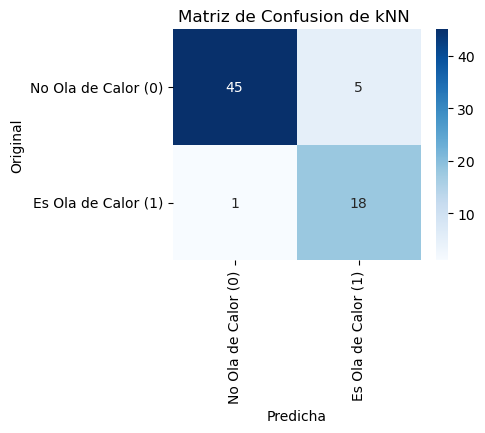

In [8]:
# Por ultimo la VISUALIZACION 

def plot_de_matriz(Y_test, Y_predict, nombre):
    matriz_confusion = metrics.confusion_matrix(Y_test, Y_predict)

    labels = ['No Ola de Calor (0)', 'Es Ola de Calor (1)']
    accuracy_ = metrics.accuracy_score(Y_test, Y_predict)
    precicion = metrics.precision_score(Y_test, Y_predict, pos_label=1, zero_division=0)
    recall = metrics.recall_score(Y_test, Y_predict, pos_label=1, zero_division=0)

    sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f"Matriz de Confusion de {nombre} ")
    plt.ylabel("Original")
    plt.xlabel("Predicha")

plt.figure(figsize=(4, 3))

plot_de_matriz(Y_test, Y_predict_kNN, "kNN")
plt.show()


## CONClUSION:

El modelamiento realizamos demostro que las variables climaticas (Presion Atmosferica, Humedad Media, Precipitacion y Radiacion UV Maxima) son predictivas para la ocurrecia de una Ola de Calor con una confianza de 84% por la metrica de Presicion. Ademas el uso del modelo de kNN valida por asi decirlo, la hipotesis inicial que teniamos, la cual esra que las condiciones atmosfericas que preceden a una Ola de Calor siguen los patrones distintivos los cuales deberian de replicarse apartir de los datos historicos. 

Por lo tanto, nos parece que anuque el modelo tenga un alto margen de error (35%) en la deteccion, esto se ve compensado por la alta presicion. Este gran porcentaje de error tambien pude darse por la clasificacion de percentil 90 de las olas de calor, generando la posibilidad de mayor cantidad de Falsos Negativos haciendo que baje el Recall.

Por ende se puede concluir que SI, es posible predecir la concurrencia de Olas de Calor en base a los datos historicos. Por lo tanto con ello dar a una relacion de si han aumentado las olas de calor a lo largo del paso del tiempo, y a su ves su concurrecia en epocas o estaciones del año.

#### Matriz de Confusion

La matriz la cual presenta una cantidad de 120 observaciones, para el modelo kNN revela la relacion entre las metricas de forma mas grafica. Ya que existe una gran cantidad de Veraderos Positivos (21) lo que da con la alta Precision al detectar muchos correctamente. Pero TAmbien tiene un fallo al detectar Falsos Negativos (11) ya que fallo al identificar 21 olas de calor que si ocurrieron. Pero algo que puede dar mucho miedo que se ve mas graficamente en la Matriz es que debido a la baja cantidad de Falsos Positivos y La gran cantidad de Verdaderos Positivos este da con una gran precision.

Por los que el modelo es bueno para identificar si "No hay Olas de calor" principalmnete. Lo cual segun lo visto en clase pasa mucho para eventos minoritarios, lo cual significa que el modelo aun tiene rango de mejora.

# MATRIZ DE CORRELACION:

--- Matriz de Correlación (Valores Numéricos) ---
                 Temperatura_Max  Humedad_Media  UVB_Maximo  Precipitacion  \
Temperatura_Max         1.000000      -0.859989    0.871578      -0.591617   
Humedad_Media          -0.859989       1.000000   -0.909641       0.604124   
UVB_Maximo              0.871578      -0.909641    1.000000      -0.560903   
Precipitacion          -0.591617       0.604124   -0.560903       1.000000   
Presion_Media          -0.760966       0.770962   -0.799060       0.335619   

                 Presion_Media  
Temperatura_Max      -0.760966  
Humedad_Media         0.770962  
UVB_Maximo           -0.799060  
Precipitacion         0.335619  
Presion_Media         1.000000  


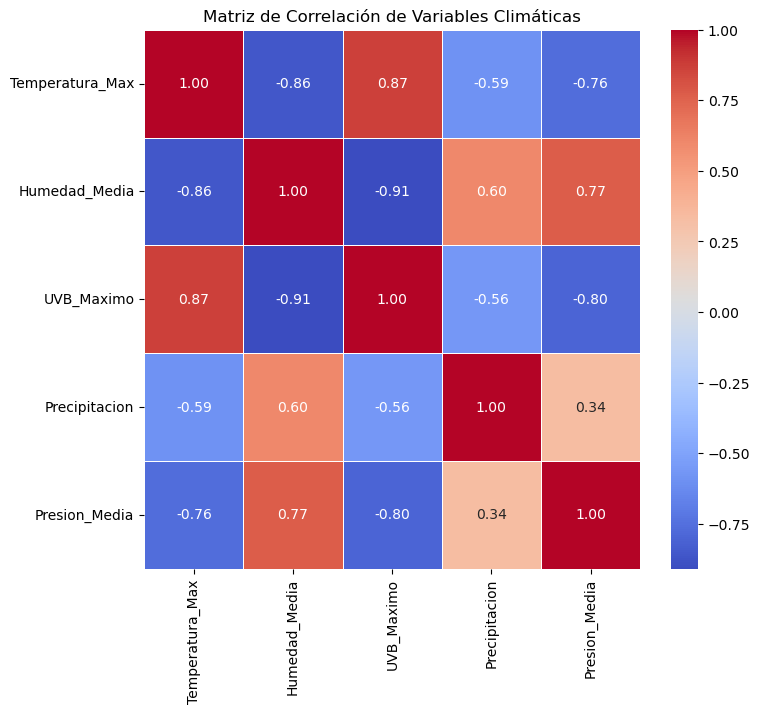

In [ ]:
columnas_numericas = [
    'Temperatura_Max', 
    'Humedad_Media', 
    'UVB_Maximo', 
    'Precipitacion', 
    'Presion_Media'
]

df_corr = df_final[columnas_numericas]
matriz_correlacion = df_corr.corr(method='pearson')

print("--- Matriz de Correlación (Valores Numéricos) ---")
print(matriz_correlacion)

plt.figure(figsize=(8, 7))
sns.heatmap(matriz_correlacion,annot=True,fmt=".2f",cmap='coolwarm',linewidths=.5)

plt.title('Matriz de Correlación de Variables Climáticas')
plt.show()